## Chat with Ed - the Expert on LLM engineering
This project will: 
- use subtitle files from Ed Donners excellent LLM engineering course on Udemy.
- use Document loading using Langchain
- use Vectorization, embeddings and store vectors in a Chroma DB
- use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.

These subtitles can be downloaded using the following process:
- Using an android phone, download Udemy app and open the LLM engineering course. 
- There is option to download the videos as single files or section wise. 
- Download them and along with those videos subs or cc are also downloaded as .srt’s.
- Plug in your laptop to the android phone using USB and select file transfer in the notification.
- Open a file explorer and copy the subtitle files (srt format)
- Here’s the location of subs in android "internal storage/android/data/com.udemy.android/files/udemy-subtitle-downloads"

the raw srt files are stored in the folder "subtitles/srts". The code below will use the langchain textloader but will preprocess the srt files to remove the timestamps.

### Note: this is only for educational and testing purposes and you should contact Ed Donnner to seek his permission if you want to use the subtitles.


In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr
import re

In [2]:
# imports for langchain

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

In [3]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [4]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("subtitles/srts/*")

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

def preprocess_srt_content(content):
    """
    Preprocess the content of an SRT file to remove timing information and the WEBVTT header.
    """
    # Remove the WEBVTT header
    content = re.sub(r'^WEBVTT\s*', '', content, flags=re.IGNORECASE)
    # Remove timing lines (e.g., 00:00.680 --> 00:08.540)
    content = re.sub(r'\d{2}:\d{2}\.\d{3} --> \d{2}:\d{2}\.\d{3}', '', content)
    # Remove extra newlines and strip leading/trailing whitespace
    return "\n".join(line.strip() for line in content.splitlines() if line.strip())

documents = []
for folder in folders:
    video_number = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/en_US.srt", loader_cls=TextLoader)
    folder_docs = loader.load()

    for doc in folder_docs:
        # Preprocess the document content
        cleaned_content = preprocess_srt_content(doc.page_content)
        # Replace the original content with the cleaned content
        doc.page_content = cleaned_content
        # Add metadata
        doc.metadata["video_number"] = video_number
        documents.append(doc)

In [6]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

In [7]:
len(chunks)

217

In [8]:
video_numbers = set(chunk.metadata['video_number'] for chunk in chunks)
print(f"Video numbers found: {', '.join(video_numbers)}")

Video numbers found: 59507785, 59472503, 59170107, 60616493, 59504887, 59297735, 59472429, 59170291, 60595637, 59473019, 59472441, 59295423, 59170043, 59472067, 59295363, 59472425, 59297723, 59473137, 59473159, 59669375, 59472011, 59295431, 59673721, 59473101, 59167015, 59670087, 60619429, 59667365, 59673639, 59169985, 59507489, 60620143, 59505329, 59670369, 59295549, 60395261, 59668181, 59671231, 60619281, 59506713, 59472491, 59295579, 59167007, 59167009, 59666211, 59673431, 59671567, 59170055, 59472017, 59473021, 59297599, 59472027, 59166947, 59473201, 60619123, 59472873, 59295601, 60614591, 60614541, 59472007, 59507313, 60619721, 59297595, 59472693, 59295527, 60619501, 59166981, 59166421, 59507423, 59170165, 59166951, 59170227, 59673663, 59670121, 59166453, 60616845, 59471979, 59670171, 59503705, 59668923, 60617163, 60616629, 59297693, 59166915, 60617259, 59166847, 59295459, 60619439, 59297593, 59295619, 59472883, 59295439, 59670933, 60619651, 59670073, 59166465, 59295429, 59669631,

## A sidenote on Embeddings, and "Auto-Encoding LLMs"

We will be mapping each chunk of text into a Vector that represents the meaning of the text, known as an embedding.

OpenAI offers a model to do this, which we will use by calling their API with some LangChain code.

This model is an example of an "Auto-Encoding LLM" which generates an output given a complete input.
It's different to all the other LLMs we've discussed today, which are known as "Auto-Regressive LLMs", and generate future tokens based only on past context.

Another example of an Auto-Encoding LLMs is BERT from Google. In addition to embedding, Auto-encoding LLMs are often used for classification.

### Sidenote

In week 8 we will return to RAG and vector embeddings, and we will use an open-source vector encoder so that the data never leaves our computer - that's an important consideration when building enterprise systems and the data needs to remain internal.

In [9]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
# Chroma is a popular open source Vector Database based on SQLLite

embeddings = OpenAIEmbeddings()

# If you would rather use the free Vector Embeddings from HuggingFace sentence-transformers
# Then replace embeddings = OpenAIEmbeddings()
# with:
# from langchain.embeddings import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Delete if already exists

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 217 documents


In [10]:
# Get one vector and find how many dimensions it has

collection = vectorstore._collection
sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"The vectors have {dimensions:,} dimensions")

The vectors have 1,536 dimensions


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [11]:
# Convert the video numbers into unique colors that we can visualize
import hashlib

def video_numbers_to_hex_colors(video_numbers):
    return [f"#{hashlib.sha256(v.encode()).hexdigest()[:6]}" for v in video_numbers]

In [13]:
# Prework

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
video_numbers = [metadata['video_number'] for metadata in result['metadatas']]
colors = video_numbers_to_hex_colors(video_numbers)

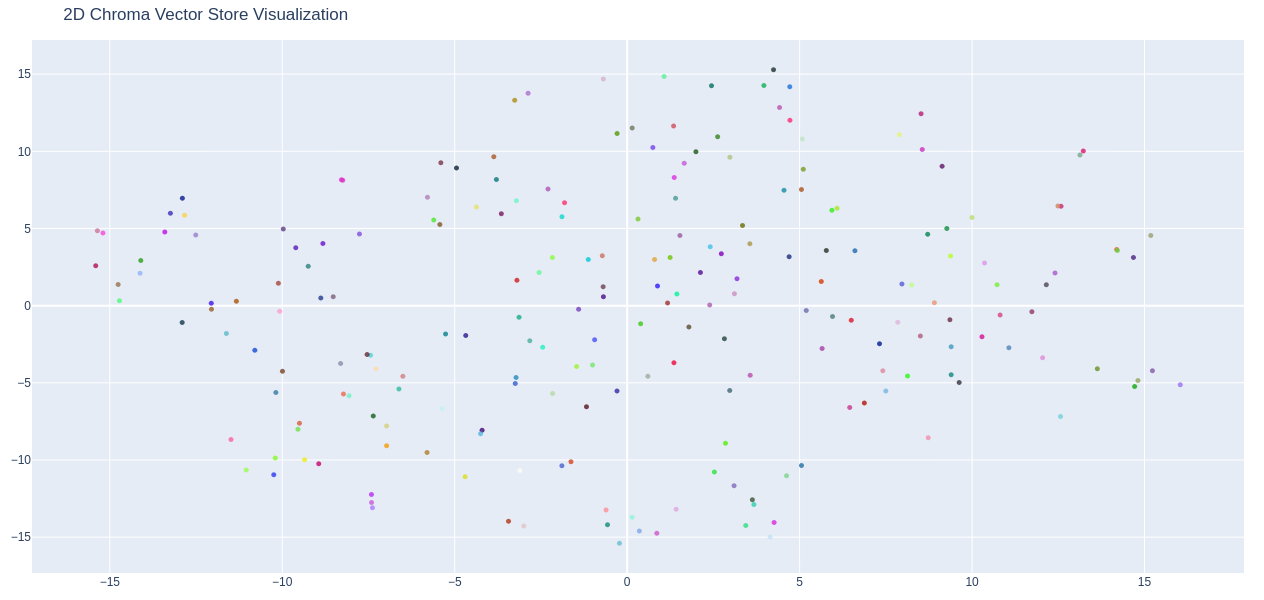

In [14]:
# We humans find it easier to visalize things in 2D!
# Reduce the dimensionality of the vectors to 2D using t-SNE
# (t-distributed stochastic neighbor embedding)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Video: {t}<br>Text: {d[:100]}..." for t, d in zip(video_numbers , documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

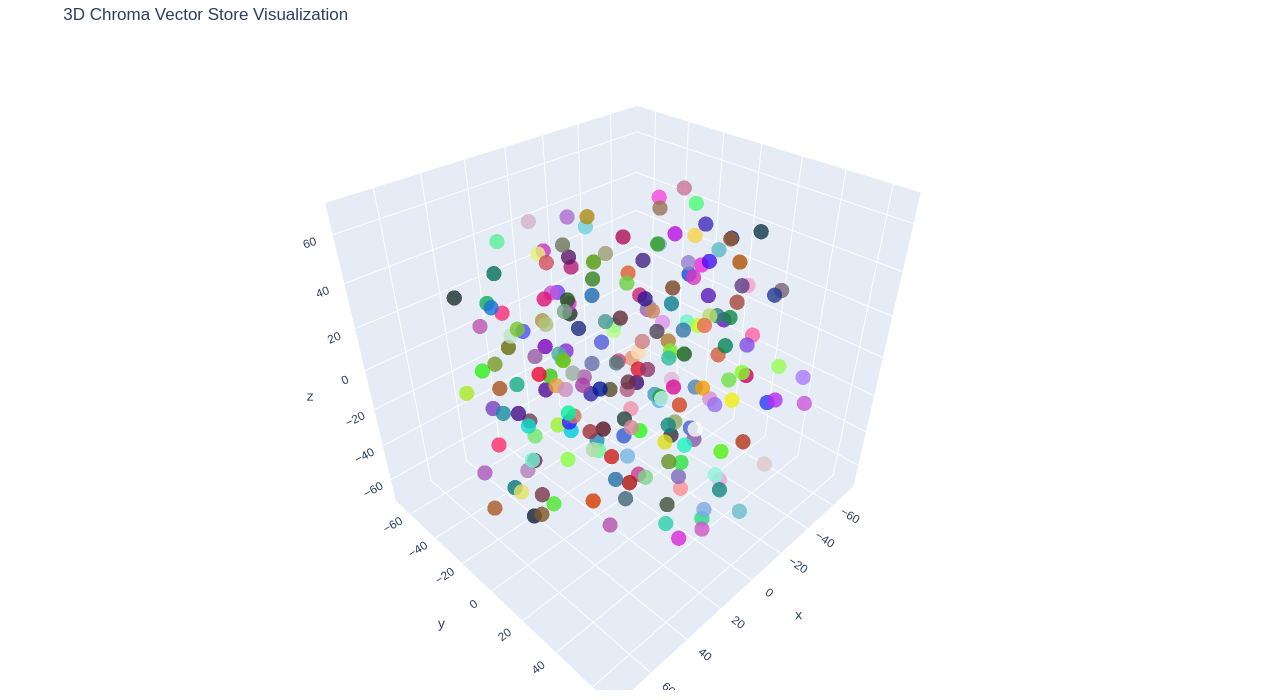

In [15]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Video: {t}<br>Text: {d[:100]}..." for t, d in zip(video_numbers, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

# Time to use LangChain to bring it all together

In [23]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

### When you run the next cell, you will get a LangChainDeprecationWarning about the simple way we use LangChain memory. They ask us to migrate to their new approach for memory. Just ignore this. Ed feels quite conflicted about this.  


In [24]:
query = "Can tell me where Ed Donner currently lives."
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Ed Donner currently lives in New York City.


In [20]:
# set up a new conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# putting it together: set up the conversation chain with the GPT 4o-mini LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [21]:
# Wrapping in a function - note that history isn't used, as the memory is in the conversation_chain

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [22]:
# And in Gradio:

view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
